In [2]:
#!unzip drive/MyDrive/Pets-data/images.zip
#!cp -r drive/MyDrive/Pets-data/annotations .
#!ls

In [47]:
import os
import yaml
from typing import Tuple, List

import torch
import torch.nn.functional as F
import torchvision
from tqdm import tqdm
from PIL import Image
import torch.nn as nn
from pydantic import BaseModel
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import copy

In [91]:
# Define constants

CONFIG_FILE_PATH = 'config-mixmatch.yaml'
IMAGE_COL_IDX = 0
CLASS_ID_COL_IDX = 1
SPECIES_COL_IDX = 2
POSSIBLE_NUM_CLASSES = {2, 37}
T = 0.5

In [6]:
class AdamOptimizerConfig(BaseModel):
    lr: float
    weight_decay: float

In [52]:
class Config(BaseModel):
    device: str
    num_classes: int
    batch_size: int
    max_num_epochs: int
    patience: int
    adam_optimizer_config: AdamOptimizerConfig
    num_batch_norm_layers_to_train_params: int
    num_batch_norm_layers_to_update_running_stats: int
    train_earlier_layers_delay: int
    n_hidden_layers_to_train: int
    labelled_data_ratio: float
    ema_decay: float
    lambda_u_epoch_max: int
    alpha: float
    lambda_u: float

In [101]:
with open(CONFIG_FILE_PATH, encoding='utf-8') as f:
    config_dict = yaml.load(f, Loader=yaml.FullLoader)

config = Config.model_validate(config_dict)

assert config.num_classes in POSSIBLE_NUM_CLASSES
assert 0 <= config.num_batch_norm_layers_to_train_params <= 36  # 36 batch norm layers in resnet34
assert 0 <= config.num_batch_norm_layers_to_update_running_stats <= 36  # 36 batch norm layers in resnet34

In [59]:
# K = 2
class TransformTwice(nn.Module):
    def __init__(self, transformation):
        super().__init__()
        self.transformation = transformation

    def __call__(self, data):
        return self.transformation(data), self.transformation(data)

In [60]:
class LabelledImageDataset(Dataset):
    def __init__(self, filenames: List[str], labels: List[int], use_augmentations: bool) -> None:
        self.filenames = filenames
        self.labels = labels
        # self.transformation = torchvision.models.ResNet34_Weights.IMAGENET1K_V1.transforms()
        self.transformation = (
            transforms.Compose([
                torchvision.models.ResNet34_Weights.IMAGENET1K_V1.transforms(),
                # transforms.RandomCrop((what size, what other size)),
                transforms.RandomHorizontalFlip(),
                # transforms.RandomRotation((-10, 10)),
                # transforms.RandomErasing(),
            ])
            if use_augmentations
            else torchvision.models.ResNet34_Weights.IMAGENET1K_V1.transforms()
        )

    def __len__(self) -> int:
        return len(self.filenames)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        image = Image.open(os.path.join('images', f'{self.filenames[idx]}.jpg')).convert('RGB')
        label = self.labels[idx]

        transformed_img = self.transformation(image)

        return transformed_img.to(config.device), torch.tensor(label).to(config.device)

In [61]:
class UnlabelledImageDataset(Dataset):
    def __init__(self, filenames: List[str], use_augmentations: bool) -> None:
        self.filenames = filenames
        # self.transformation = torchvision.models.ResNet34_Weights.IMAGENET1K_V1.transforms()
        self.transformation = (
            transforms.Compose([
                torchvision.models.ResNet34_Weights.IMAGENET1K_V1.transforms(),
                # transforms.RandomCrop((what size, what other size)),
                TransformTwice(transforms.RandomHorizontalFlip()),
                # transforms.RandomRotation((-10, 10)),
                # transforms.RandomErasing(),
            ])
            if use_augmentations
            else torchvision.models.ResNet34_Weights.IMAGENET1K_V1.transforms()
        )

    def __len__(self) -> int:
        return len(self.filenames)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        image = Image.open(os.path.join('images', f'{self.filenames[idx]}.jpg')).convert('RGB')

        transformed_img, transformed_img_2 = self.transformation(image)

        return transformed_img.to(config.device), transformed_img_2.to(config.device)

In [62]:
def get_image_names_and_labels(annotations_file_path: str, num_classes: int) -> Tuple[List[str], List[int]]:
    filenames: List[str] = []
    labels: List[int] = []

    with open(annotations_file_path, encoding='utf-8') as f:
        lines = f.readlines()

    label_col_idx = SPECIES_COL_IDX if num_classes == 2 else CLASS_ID_COL_IDX

    for line in lines:
        line_split = line.split()
        filenames.append(line_split[IMAGE_COL_IDX])
        labels.append(int(line_split[label_col_idx]) - 1)

    return filenames, labels

In [63]:
def get_batch_norm_layers(model: nn.Module) -> List[nn.Module]:
    return [
        module
        for module in model.modules()
        if isinstance(module, nn.BatchNorm2d)
    ]

In [64]:
def get_pretrained_model_with_trainable_last_layer(num_batch_norm_layers_to_train_params: int) -> nn.Module:
    model = torchvision.models.resnet34(weights=torchvision.models.ResNet34_Weights.IMAGENET1K_V1)

    for param in model.parameters():
        param.requires_grad = False

    batch_norm_layers = get_batch_norm_layers(model)
    batch_norm_layers_to_train_params = batch_norm_layers[-num_batch_norm_layers_to_train_params:] if num_batch_norm_layers_to_train_params else []

    for batch_norm_layer in batch_norm_layers_to_train_params:
        for param in batch_norm_layer.parameters():
            param.requires_grad = True

    model.fc = nn.Linear(in_features=model.fc.in_features, out_features=config.num_classes)

    return model.to(config.device)

In [65]:
def make_hidden_layers_trainable(model: nn.Module, number_of_hidden_layers_to_train: int) -> nn.Module:
    trainable_layers = [layer for layer in model.modules() if not isinstance(layer, torchvision.models.resnet.ResNet) and not isinstance(layer, torchvision.models.resnet.BasicBlock) and not isinstance(layer, nn.Sequential) and not isinstance(layer, nn.Sequential) and len(list(layer.parameters())) > 0]
    trainable_layers = list(reversed(trainable_layers[:-1]))

    for l in trainable_layers[:number_of_hidden_layers_to_train]:
        for p in l.parameters():
            p.requires_grad = True

    return model

In [ ]:
def get_model_accuracy(model: nn.Module, data_loader: DataLoader) -> float:
    correct_predictions_cnt = 0
    total_predictions_cnt = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc='Computing accuracy'):
            outputs = model(inputs)
            correct_predictions_cnt += (torch.argmax(outputs, axis=1) == labels).sum()
            total_predictions_cnt += len(outputs)
    return correct_predictions_cnt / total_predictions_cnt

In [67]:
def mix_up(X_1, X_2, Y_1, Y_2):
    assert X_1.shape == X_2.shape, 'mix_up: inputs must have same size'
    X = []
    Y = []
    for i in range(len(X_1)):
        x_1 = X_1[i]
        x_2 = X_2[i]
        y_1 = Y_1[i]
        y_2 = Y_2[i]
        l = np.random.beta(config.alpha, config.alpha)
        l = max(l, (1-l))
        x = l * x_1 + (1-l) * x_2
        y = l * y_1 + (1-l) * y_2

        X.append(x)
        Y.append(y)
    return torch.stack(X), torch.stack(Y)

In [ ]:
def linear_rampup(epoch):
    return float(min(epoch / config.lambda_u_epoch_max, 1))

In [ ]:
class SemiLoss(object):
    def __call__(self, outputs_x, targets_x, outputs_u, targets_u, epoch):
        probs_u = torch.softmax(outputs_u, dim=1)

        Lx = -torch.mean(torch.sum(F.log_softmax(outputs_x, dim=1) * targets_x, dim=1))
        Lu = torch.mean((probs_u - targets_u)**2)

        return Lx, Lu, config.lambda_u * linear_rampup(epoch)

In [70]:
def update_ema_parameters(model, ema_model, ema_decay=0.999):
    with torch.no_grad():
        for ema_param, param in zip(ema_model.parameters(), model.parameters()):
            ema_param.data.copy_(ema_param.data * ema_decay + (1 - ema_decay) * param.data)

In [93]:
def infinite_batch_generator(loader: DataLoader):
    while True:
        for batch in loader:
            yield batch


def train_single_epoch(
        model: nn.Module,
        ema_model: nn.Module,        
        train_data_loader: DataLoader,
        unlabelled_train_data_loader: DataLoader,
        criterion: SemiLoss,
        optimizer: torch.optim.Optimizer,
        num_batch_norm_layers_to_update_running_stats: int,
        epoch: int,
        ) -> float:
    model.train()
    batch_norm_layers = get_batch_norm_layers(model)
    batch_norm_layers_to_not_update_running_stats = (
        batch_norm_layers[:-num_batch_norm_layers_to_update_running_stats]
        if num_batch_norm_layers_to_update_running_stats
        else batch_norm_layers
    )
    for batch_norm_layer in batch_norm_layers_to_not_update_running_stats:
        batch_norm_layer.eval()
    train_loss_sum = 0.0
    train_samples_cnt = 0

    unlabelled_generator = infinite_batch_generator(unlabelled_train_data_loader)

    for labelled_inputs, labelled_targets in tqdm(train_data_loader, desc='Training model'):

        labelled_targets = F.one_hot(labelled_targets, config.num_classes)
        unlabelled_inputs_1, unlabelled_inputs_2 = next(unlabelled_generator)
        unlabelled_inputs = torch.cat([unlabelled_inputs_1, unlabelled_inputs_2])

        # Calculated the pseudo label for each of the augmented unlabeled data point
        with torch.no_grad():
            u_o_1 = model(unlabelled_inputs_1)
            u_o_2 = model(unlabelled_inputs_2)
            unlabelled_targets = (F.softmax(u_o_1, dim=1) + F.softmax(u_o_2, dim=1)) / 2
            unlabelled_targets = unlabelled_targets**(1/T)
            unlabelled_targets = unlabelled_targets / unlabelled_targets.sum(dim=1, keepdim=True)

        all_inputs = torch.cat([labelled_inputs, unlabelled_inputs_1, unlabelled_inputs_2])
        all_targets = torch.cat([labelled_targets, unlabelled_targets, unlabelled_targets])
        idxs = np.random.permutation(len(all_inputs))
        all_inputs = all_inputs[idxs]
        all_targets = all_targets[idxs]

        X, targets_X = mix_up(labelled_inputs, all_inputs[:len(labelled_inputs)], labelled_targets, all_targets[:len(labelled_inputs)])
        U, targets_U = mix_up(unlabelled_inputs, all_inputs[len(labelled_inputs):], torch.cat([unlabelled_targets, unlabelled_targets]), all_targets[len(labelled_inputs):])

        outputs_X = model(X)
        outputs_U = model(U)

        LX, LU, lamb_u = criterion(outputs_X, targets_X, outputs_U, targets_U, epoch)

        optimizer.zero_grad()
        loss = LX + lamb_u * LU
        loss.backward()
        optimizer.step()
        update_ema_parameters(model, ema_model, config.ema_decay)
        train_loss_sum += loss.item() * (len(outputs_X) + len(outputs_U))
        train_samples_cnt += len(outputs_X) + len(outputs_U)

    return train_loss_sum / train_samples_cnt

In [72]:
def save_checkpoint(model: nn.Module, optimizer: torch.optim.Optimizer) -> Tuple[nn.Module, torch.optim.Optimizer]:
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint, 'checkpoint.pt')

In [73]:
def load_checkpoint(model: nn.Module, optimizer: torch.optim.Optimizer) -> None:
    checkpoint = torch.load('checkpoint.pt')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [74]:
filenames_trainval, labels_trainval = get_image_names_and_labels('annotations/trainval.txt', num_classes=config.num_classes)
filenames_test, labels_test = get_image_names_and_labels('annotations/test.txt', num_classes=config.num_classes)
filenames_train, filenames_val, labels_train, labels_val = train_test_split(filenames_trainval, labels_trainval, test_size=0.2, stratify=labels_trainval)

filenames_train, unlabelled_filenames_train, labels_train, _ = train_test_split(filenames_train, labels_train, train_size=config.labelled_data_ratio, stratify=labels_train)
dataset_train = LabelledImageDataset(filenames_train, labels_train, use_augmentations=True)
unlabelled_dataset_train = UnlabelledImageDataset(unlabelled_filenames_train, use_augmentations=True)

dataset_val = LabelledImageDataset(filenames_val, labels_val, use_augmentations=False)
dataset_test = LabelledImageDataset(filenames_test, labels_test, use_augmentations=False)

unlabelled_train_data_loader = DataLoader(unlabelled_dataset_train, batch_size=config.batch_size, shuffle=True)
train_data_loader = DataLoader(dataset_train, batch_size=config.batch_size, shuffle=True)
val_data_loader = DataLoader(dataset_val, batch_size=config.batch_size, shuffle=False)
test_data_loader = DataLoader(dataset_test, batch_size=config.batch_size, shuffle=False)

In [100]:
# Train using pseudo labelling
def train_model():
    model = get_pretrained_model_with_trainable_last_layer(config.num_batch_norm_layers_to_train_params)
    ema_model = copy.deepcopy(model)

    criterion = SemiLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config.adam_optimizer_config.lr, weight_decay=config.adam_optimizer_config.weight_decay)

    max_val_accuracy = float('-inf')
    argmax_epoch = -1

    accuracies = []

    for epoch in range(config.max_num_epochs):
        print(f'Epoch #{epoch}:')
        train_loss = train_single_epoch(model, ema_model, train_data_loader, unlabelled_train_data_loader, criterion, optimizer, config.num_batch_norm_layers_to_update_running_stats, epoch)
        print(f'Train loss: {train_loss}')
        val_accuracy = get_model_accuracy(ema_model, val_data_loader)
        accuracies.append(val_accuracy)
        if val_accuracy > max_val_accuracy:
            print(f'Validation accuracy: {100 * val_accuracy:.2f}% (new best)')
            max_val_accuracy = val_accuracy
            argmax_epoch = epoch
            save_checkpoint(ema_model, optimizer)
            print('Checkpoint saved')
        else:
            print(f'Validation accuracy: {100 * val_accuracy:.2f}% (worse than {100 * max_val_accuracy:.2f}% of epoch {argmax_epoch})')
            if epoch > argmax_epoch + config.patience:
                print(f'Early stopping')
                break
        # Start training earlier layers
        if epoch == config.train_earlier_layers_delay and config.n_hidden_layers_to_train > 0:
            print (f'Making last {config.n_hidden_layers_to_train} hidden layers trainable')
            make_hidden_layers_trainable(model, config.n_hidden_layers_to_train)
            optimizer = torch.optim.Adam(model.parameters(), lr=config.adam_optimizer_config.lr / 100, weight_decay=config.adam_optimizer_config.weight_decay)
        print()
    return ema_model, optimizer, accuracies

In [102]:
# Train the model
model, optimizer, accuracies = train_model()


Training model: 100%|██████████| 10/10 [00:02<00:00,  3.63it/s]


Train loss: 1.545376811599323


Computing accuracy: 100%|██████████| 23/23 [00:02<00:00,  9.40it/s]


Validation accuracy: 61.41% (new best)
Checkpoint saved

Epoch #50:


Training model: 100%|██████████| 10/10 [00:02<00:00,  3.68it/s]


Train loss: 1.5353658255468854


Computing accuracy: 100%|██████████| 23/23 [00:02<00:00,  9.12it/s]


Validation accuracy: 62.77% (new best)
Checkpoint saved

Epoch #51:


Training model: 100%|██████████| 10/10 [00:02<00:00,  3.65it/s]


Train loss: 1.517876562776096


Computing accuracy: 100%|██████████| 23/23 [00:02<00:00,  9.37it/s]


Validation accuracy: 63.86% (new best)
Checkpoint saved

Epoch #52:


Training model: 100%|██████████| 10/10 [00:02<00:00,  3.66it/s]


Train loss: 1.4820751763513307


Computing accuracy: 100%|██████████| 23/23 [00:02<00:00,  9.15it/s]


Validation accuracy: 64.81% (new best)
Checkpoint saved

Epoch #53:


Training model: 100%|██████████| 10/10 [00:02<00:00,  3.71it/s]


Train loss: 1.4645052392681865


Computing accuracy: 100%|██████████| 23/23 [00:02<00:00,  9.28it/s]


Validation accuracy: 66.17% (new best)
Checkpoint saved

Epoch #54:


Training model: 100%|██████████| 10/10 [00:02<00:00,  3.57it/s]


Train loss: 1.3684705393727892


Computing accuracy: 100%|██████████| 23/23 [00:02<00:00,  9.60it/s]


Validation accuracy: 67.53% (new best)
Checkpoint saved

Epoch #55:


Training model: 100%|██████████| 10/10 [00:02<00:00,  3.65it/s]


Train loss: 1.4650118820672373


Computing accuracy: 100%|██████████| 23/23 [00:02<00:00,  9.29it/s]


Validation accuracy: 68.75% (new best)
Checkpoint saved

Epoch #56:


Training model: 100%|██████████| 10/10 [00:02<00:00,  3.58it/s]


Train loss: 1.486402016380359


Computing accuracy: 100%|██████████| 23/23 [00:02<00:00,  9.70it/s]


Validation accuracy: 70.38% (new best)
Checkpoint saved

Epoch #57:


Training model: 100%|██████████| 10/10 [00:02<00:00,  3.68it/s]


Train loss: 1.4357058718577187


Computing accuracy:  70%|██████▉   | 16/23 [00:01<00:00,  9.15it/s]

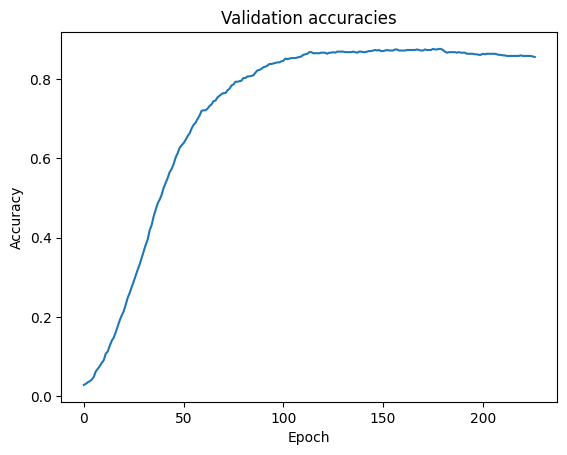

In [99]:
plt.title('Validation accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(torch.tensor(accuracies).cpu().numpy())

plt.show()

In [90]:
load_checkpoint(model, optimizer)
print('Checkpoint loaded')

test_accuracy = get_model_accuracy(model, test_data_loader)

print(f'Test accuracy: {100 * test_accuracy:.2f}%')

Checkpoint loaded


Computing accuracy: 100%|██████████| 115/115 [00:14<00:00,  8.06it/s]

Test accuracy: 86.35%
